In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time

from datetime import datetime
import numpy as np
import pandas as pd
import glob, os, sys, math, warnings
import matplotlib.pyplot as  plt
import copy, time, glob, os, sys
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# customized ftns 
from helpers import *
from utilities import *
from model import *
from train import train_all_single_policies
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)
models_path = './models/' 

/home/sam/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Load raw data

In [2]:
# %%time
game_id = '0021500196'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])
print('raw events shape:', events_df.shape)
events_df.head(3)

raw events shape: (234, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,716.37,"{'abbreviation': 'LAC', 'players': [{'playerid...","[[1, 1448224810037, 720.0, 24.0, None, [[-1, -...",[0],"Empty DataFrame Columns: [GAME_ID, EVENTNUM, E...",1,720.00,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,701.37,"{'abbreviation': 'LAC', 'players': [{'playerid...","[[1, 1448224810037, 720.0, 24.0, None, [[-1, -...","[1, 2]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,720.00,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,682.36,"{'abbreviation': 'LAC', 'players': [{'playerid...","[[1, 1448224825036, 707.33, 11.37, None, [[-1,...","[3, 4]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,707.33,"{'abbreviation': 'TOR', 'players': [{'playerid..."


#### Get some suplementary data

In [3]:
# # play id to play roles/positions
# id_role = id_position(events_df)
# check_game_roles_duplicates(id_role)

# # its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order
# # ddentify defending and offending runs (this is included in process_moments)
# court_index = Data.load_csv('./meta_data/court_index.csv')
# court_index = dict(zip(court_index.game_id, court_index.court_position))

# # home and visitor ids
# homeid = events_df.loc[0].home['teamid']
# awayid = events_df.loc[0].visitor['teamid']

### FILTER EVENTS

In [4]:
# # filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation
# use_event = [1, 2]
# discard_event = [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 18]
# events = filter_event_type(events_df, discard_event)

In [5]:
events_df.shape

(234, 8)

In [6]:
events_df.head()

,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,716.37,"{'abbreviation': 'LAC', 'players': [{'playerid...","[[1, 1448224810037, 720.0, 24.0, None, [[-1, -...",[0],"Empty DataFrame Columns: [GAME_ID, EVENTNUM, E...",1,720.00,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,701.37,"{'abbreviation': 'LAC', 'players': [{'playerid...","[[1, 1448224810037, 720.0, 24.0, None, [[-1, -...","[1, 2]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,720.00,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,682.36,"{'abbreviation': 'LAC', 'players': [{'playerid...","[[1, 1448224825036, 707.33, 11.37, None, [[-1,...","[3, 4]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,707.33,"{'abbreviation': 'TOR', 'players': [{'playerid..."
3,670.36,"{'abbreviation': 'LAC', 'players': [{'playerid...","[[1, 1448224844036, 688.32, 6.32, None, [[-1, ...","[5, 6]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,688.32,"{'abbreviation': 'TOR', 'players': [{'playerid..."
4,636.34,"{'abbreviation': 'LAC', 'players': [{'playerid...","[[1, 1448224856036, 676.32, 13.32, None, [[-1,...",[7],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,676.32,"{'abbreviation': 'TOR', 'players': [{'playerid..."


In [7]:
events_df.loc[2].playbyplay

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,TEAM,time_left,event_str
2,0021500196,2,2,1,1,3:41 PM,11:45,MISS Redick 22' Jump Shot,None,None,...,0,0,None,NaN,None,None,None,LAC,705,miss
3,0021500196,3,4,0,1,3:41 PM,11:44,None,None,Biyombo REBOUND (Off:0 Def:1),...,0,0,None,NaN,None,None,None,TOR,704,rebound
4,0021500196,4,2,1,1,3:41 PM,11:25,None,None,MISS Lowry 20' Jump Shot,...,0,0,None,NaN,None,None,None,TOR,685,miss
5,0021500196,5,4,0,1,3:41 PM,11:24,Jordan REBOUND (Off:0 Def:1),None,None,...,0,0,None,NaN,None,None,None,LAC,684,rebound


In [ ]:
events_df.dropna(subset=['playbyplay'], inplace=True)
events_df.reset_index(drop=True, inplace=True)

use_events = [1,2]
def filter_events(row, use_events):
    pbp = row['playbyplay'].copy()
    # when theres no playbyplay data
    if len(pbp) == 0:
        return []
    time_lefts = pbp['time_left'].values
    n_events = len(pbp)
    result = []
    event_i = []
    init = 0
    start_time = time_lefts[init]
    for i in row['moments']:
        if i[2] > start_time:
            event_i.append(i)
        else:
            result.append(event_i)
            if init < n_events - 1:
                init += 1
                start_time = time_lefts[init]
                event_i = []
    select_events = [result[i] for i in range(n_events) if pbp['EVENTMSGTYPE'].values[i] in use_events]
    return select_events

In [ ]:
events_df['n'] = events_df.apply(lambda row: filter_events(row, use_events), axis=1)

In [ ]:
events_df.head()

In [ ]:
events_df.playbyplay[2]

In [ ]:
events_df.moments[2]

In [ ]:
len(events_df.n[1])

In [ ]:
# only use miss or make, and some playbyplay is none

In [ ]:
events_df.n[1]

IndexError: index 625 is out of bounds for axis 0 with size 625

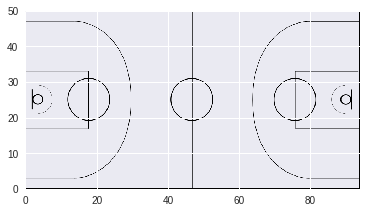

In [10]:
P = PlotGame('0021500196', main_dir, game_dir)
for i in range(715):
    P.load_moment2img(game_data, 2, i)

In [ ]:
images = glob.glob('../data/game0021500196/event2/' + "*.png")
images = sorted(images, key=lambda x: int(x.split('.')[2].split('/')[-1]))
make_video(images, '../data/game0021500196/event2/2.mp4', 15)